In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Read Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_dir = os.path.join('/content/drive/My Drive/dataset_son', 'train')
validation_dir = os.path.join('/content/drive/My Drive/dataset_son', 'validation')
test_dir = os.path.join('/content/drive/My Drive/dataset_son', 'test')

SEED = 1234
tf.random.set_seed(SEED) 

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             label_mode="categorical",
                                             seed=SEED,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             label_mode="categorical",
                                             seed=SEED,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  label_mode="categorical",
                                                  seed=SEED,
                                                  image_size=IMG_SIZE)


In [ ]:
tf.data.experimental.cardinality(test_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=32>

# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.08,0.08),width_factor=(0,0))
])

## Visualization Augmentation

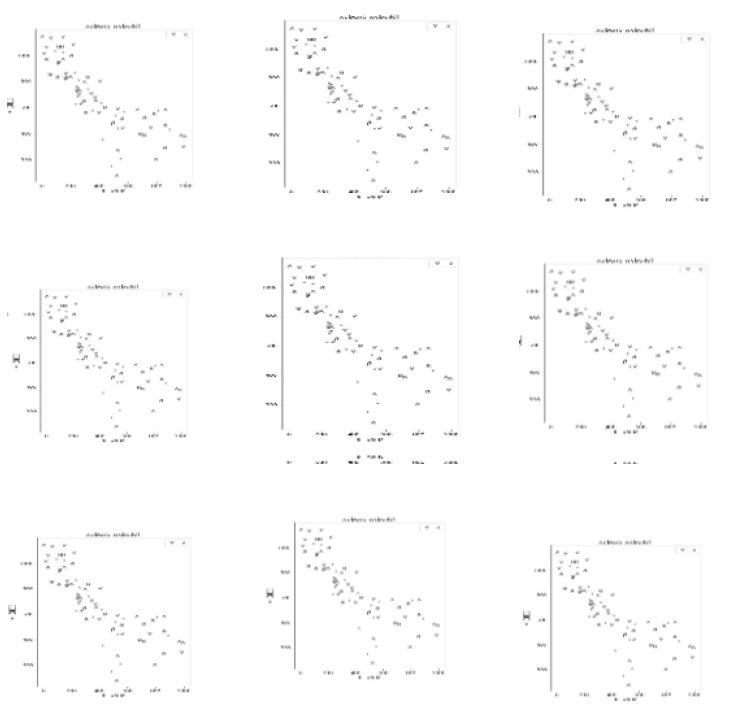

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(13, 13))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Preprocess Dataset

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

print(f"Görsel boyutu: {IMG_SIZE}\nGörsel şekli: {IMG_SHAPE}")

94773248/94765736 [==============================] - 1s 0us/step
Görsel boyutu: (160, 160)
Görsel şekli: (160, 160, 3)


In [ ]:
#This feature extractor converts each "160x160x3" image into a "5x5x2048" feature block. 
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


# Create Model

In [ ]:
#Transfer Learning False/True
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#To generate estimates from the #features block, 
#a tf.keras.layers.GlobalAveragePooling2D layer is used to convert the features to a single 2048-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
layer_1 = tf.keras.layers.Dense(units=2048, activation='relu')
layer_1_batch = layer_1(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(5,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [ ]:
prediction_batch[:5]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0.10408273, 0.06120311, 0.053768  , 0.12386325, 0.6570829 ],
       [0.12225026, 0.05276173, 0.07152463, 0.17345333, 0.58001006],
       [0.33402255, 0.06662208, 0.11058328, 0.1202975 , 0.36847457],
       [0.17788011, 0.03463619, 0.08744172, 0.19712876, 0.50291324],
       [0.14626408, 0.04446785, 0.07989224, 0.18859841, 0.54077744]],
      dtype=float32)>

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layer_1(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              419635

In [ ]:
initial_epochs = 16
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/16
94/94 [==============================] - 496s 5s/step - loss: 0.6793 - accuracy: 0.7003 - val_loss: 0.6027 - val_accuracy: 0.7550
Epoch 2/16
94/94 [==============================] - 31s 320ms/step - loss: 0.3597 - accuracy: 0.8533 - val_loss: 0.4299 - val_accuracy: 0.8180
Epoch 3/16
94/94 [==============================] - 31s 315ms/step - loss: 0.2851 - accuracy: 0.8847 - val_loss: 0.3289 - val_accuracy: 0.8740
Epoch 4/16
94/94 [==============================] - 31s 315ms/step - loss: 0.2282 - accuracy: 0.9150 - val_loss: 0.3103 - val_accuracy: 0.8730
Epoch 5/16
94/94 [==============================] - 31s 315ms/step - loss: 0.1933 - accuracy: 0.9350 - val_loss: 0.2572 - val_accuracy: 0.9020
Epoch 6/16
94/94 [==============================] - 31s 318ms/step - loss: 0.1600 - accuracy: 0.9497 - val_loss: 0.2459 - val_accuracy: 0.9030
Epoch 7/16
94/94 [==============================] - 31s 317ms/step - loss: 0.1437 - accuracy: 0.9523 - val_loss: 0.2379 - val_accuracy: 0.9090
E

# Results

## Draw Accuracy Plot

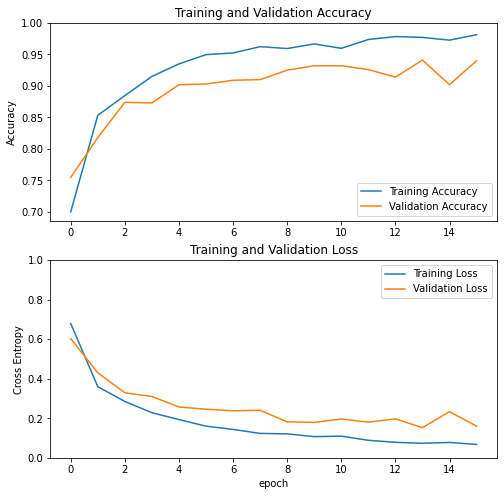

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Classification Metrics

In [ ]:
model.evaluate(train_dataset,verbose=1)
model.evaluate(validation_dataset,verbose=1)
model.evaluate(test_dataset,verbose=1)

32/32 [==============================] - 183s 4s/step - loss: 0.1817 - accuracy: 0.9380


[0.18165284395217896, 0.9380000233650208]

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Evaluation Metrics

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis =1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
#convert binary to decimal
b=np.argmax(correct_labels, axis=1)

In [ ]:
precision = precision_score(b, predicted_labels, average="macro")
recall = recall_score(b, predicted_labels, average="macro")
f1 = f1_score(b, predicted_labels, average="macro")

print("Precision: " + str(round(precision, 6)))
print("Recall: " + str(round(recall, 6)))
print("f1: " + str(round(f1, 6)))

Precision: 0.939429
Recall: 0.938
f1: 0.937944


## Confusion Matrix

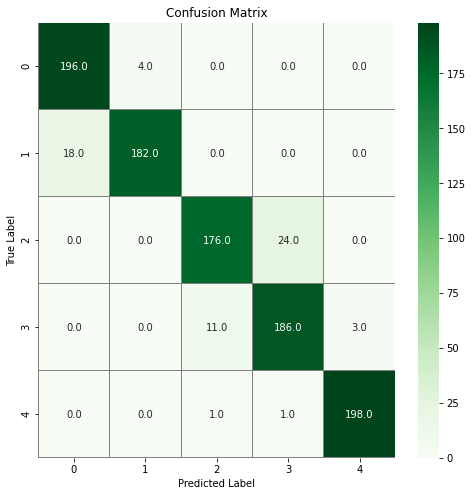

In [ ]:
import seaborn as sns
disp = confusion_matrix(y_true=b, y_pred=predicted_labels)

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(disp, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save Model

In [ ]:
tf.keras.models.save_model(model,'resnet.hdf5')